In [136]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab import drive
import kagglehub
import zipfile

# drive.mount('/content/drive/', force_remount=True)

## Cleaning and Preparing Data

### Loading Dataframes


In [137]:
# np.random.seed(0) # Reproducability
# read the dataset using the compression zip
# https://www.kaggle.com/datasets/mryanm/luflow-network-intrusion-detection-data-set/data
file_names = ['2022.06.13.csv', '2022.06.14.csv', '2022.06.12.csv', '2021.02.06.csv']
df = pd.DataFrame()
for file_name in file_names:
  df_temp = pd.read_csv(f'/content/drive/MyDrive/Capstone Project/AI Model Training/intrusion-detection/{file_name}')
  df = pd.concat([df, df_temp])

# Shuffle df
df = df.sample(frac=1).reset_index(drop=True)
df.drop_duplicates(inplace=True)

# # Dropping uneccessary columns
# df.drop('time_end', axis=1, inplace=True, errors='ignore')
# df.drop('time_start', axis=1, inplace=True, errors='ignore')
# df.drop('total_entropy', axis=1, inplace=True, errors='ignore')


# transform 'label' to numbers
def transform(label):
  if label == 'benign': return 0
  if label == 'outlier': return 1
  return 2

df['label'] = df['label'].apply(transform)

### Relationships by mean values

Index(['avg_ipt', 'bytes_in', 'bytes_out', 'dest_ip', 'dest_port', 'entropy',
       'num_pkts_out', 'num_pkts_in', 'proto', 'src_ip', 'src_port',
       'time_end', 'time_start', 'total_entropy', 'label', 'duration'],
      dtype='object')
Unique values in column avg_ipt: 71613
Unique values in column bytes_in: 23320
Unique values in column bytes_out: 47796
Unique values in column dest_ip: 1
Unique values in column dest_port: 61228
Unique values in column entropy: 642809
Unique values in column num_pkts_out: 256
Unique values in column num_pkts_in: 256
Unique values in column proto: 5
Unique values in column src_ip: 1
Unique values in column src_port: 63367
Unique values in column time_end: 1810993
Unique values in column time_start: 1810455
Unique values in column total_entropy: 707878
Unique values in column label: 3
Unique values in column duration: 544550


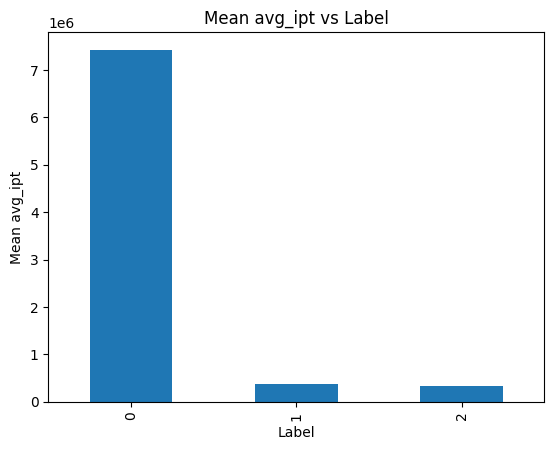

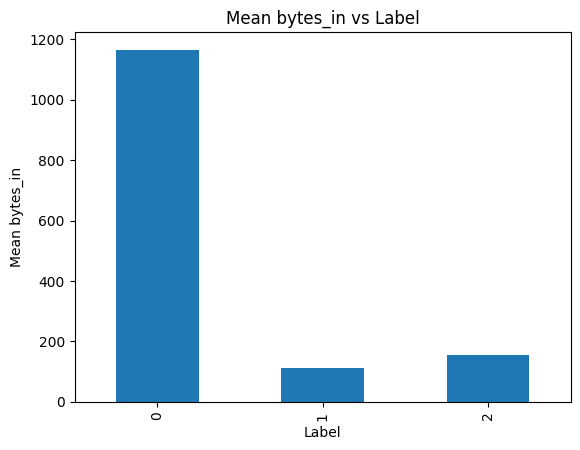

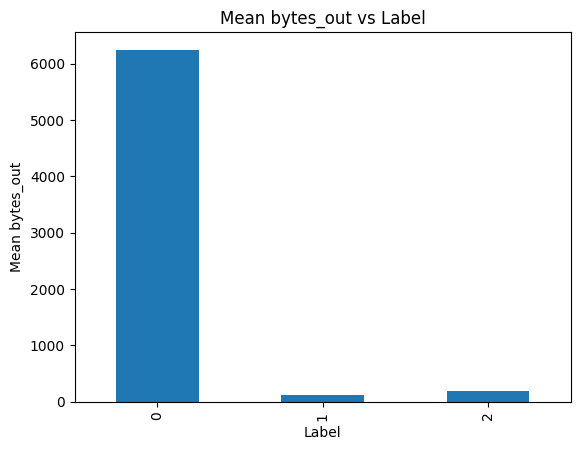

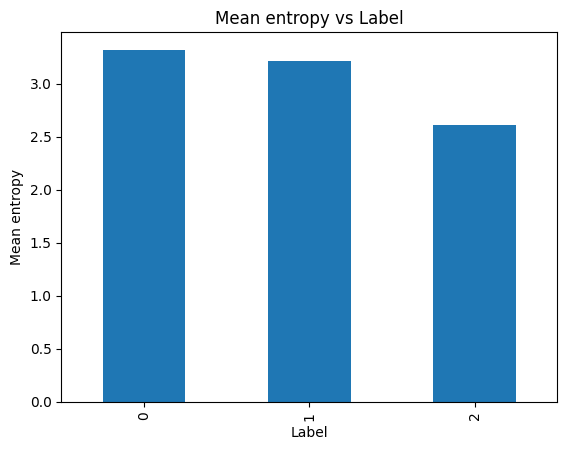

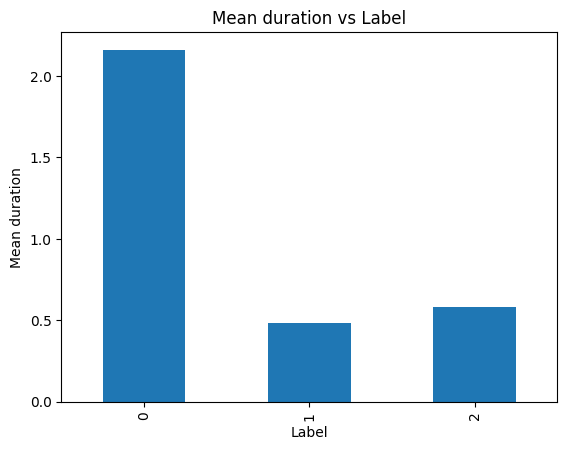

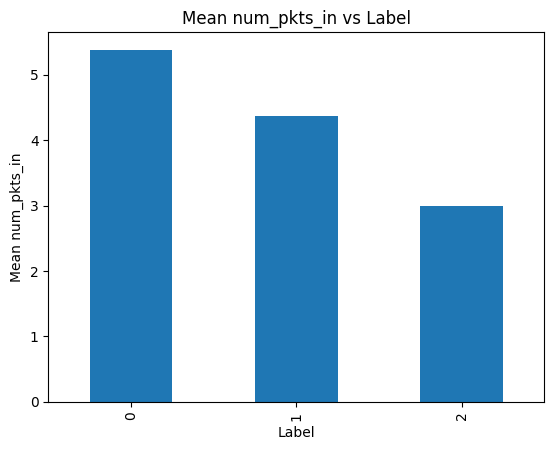

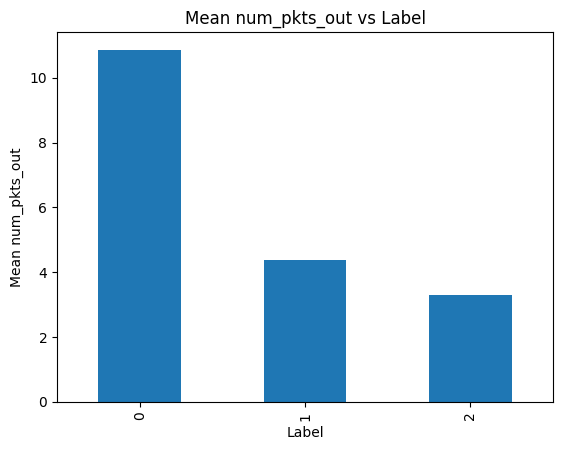

In [138]:
print(df.columns)
for c in df.columns:
  print(f'Unique values in column {c}: {df[c].nunique()}')

def Plot_Mean_Values_Vs_Label(c):
  if c not in df.columns: return
  plt.figure()
  df.groupby('label')[c].mean().plot(kind='bar')
  plt.title(f'Mean {c} vs Label')
  plt.xlabel('Label')
  plt.ylabel(f'Mean {c}')
  plt.show()

Plot_Mean_Values_Vs_Label('avg_ipt')
Plot_Mean_Values_Vs_Label('bytes_in')
Plot_Mean_Values_Vs_Label('bytes_out')
Plot_Mean_Values_Vs_Label('entropy')
Plot_Mean_Values_Vs_Label('duration')
Plot_Mean_Values_Vs_Label('num_pkts_in')
Plot_Mean_Values_Vs_Label('num_pkts_out')


*src_ip* and *dest_ip* have no unique values due to anonymization. *time_start* and *time_end* should be dropped and interpreted by duration instead. *entropy* yields a similar mean for each class of *label* meaning it won't provide much positive or negative information gain. *num_pkts_in* is mostly evenly distributed and will not provide much information gain either. Contrary, *num_pkts_out* is skewed/biased and could be useful in model training.

### Plot by frequency

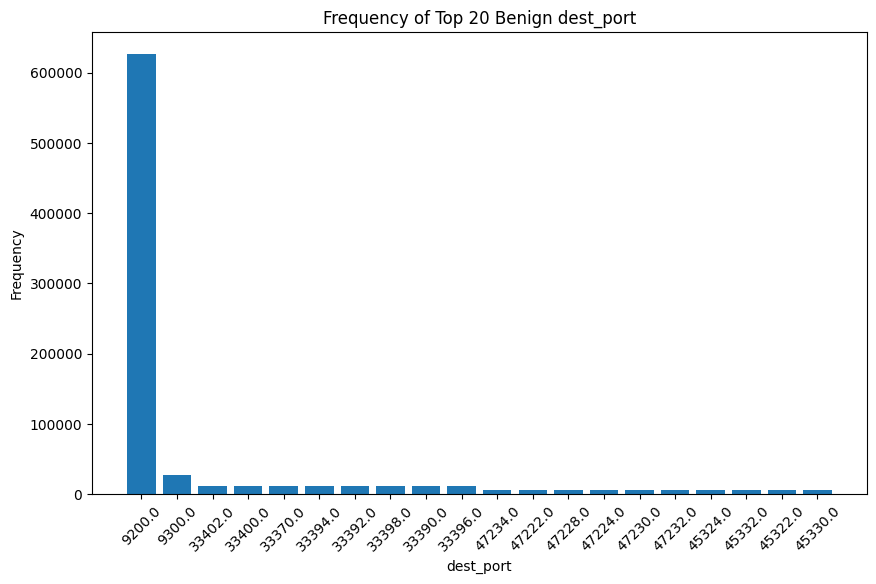

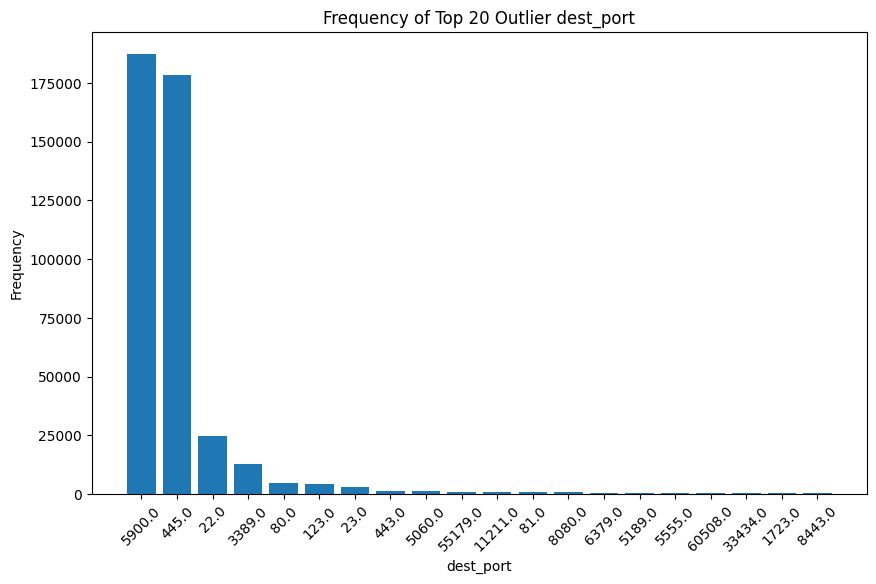

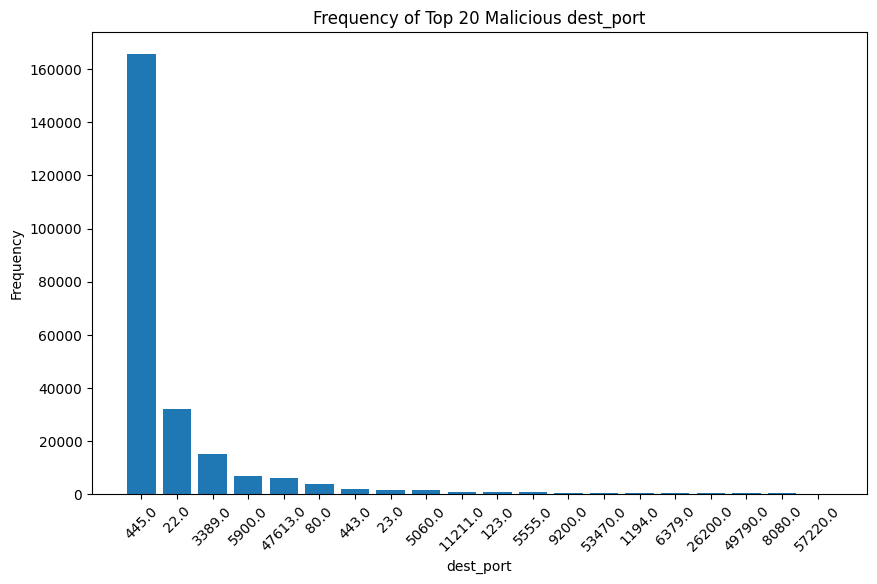

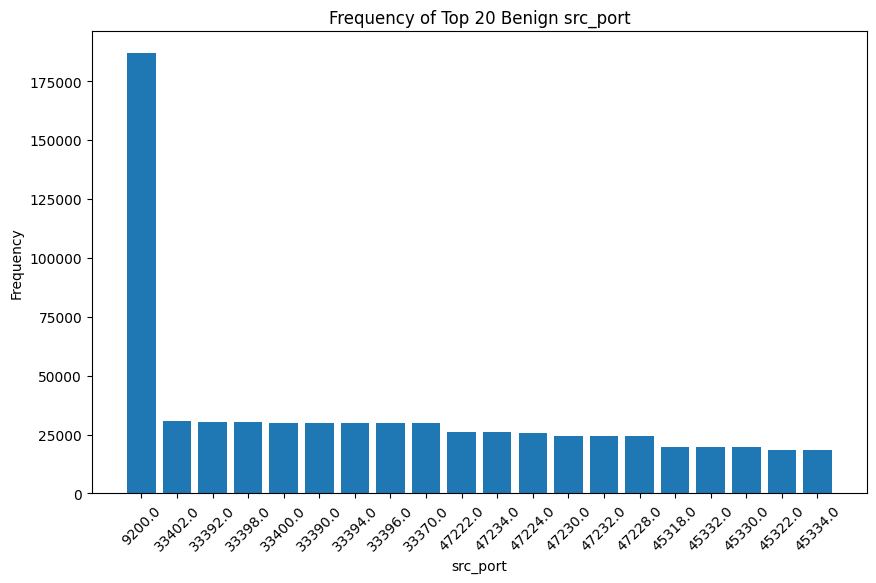

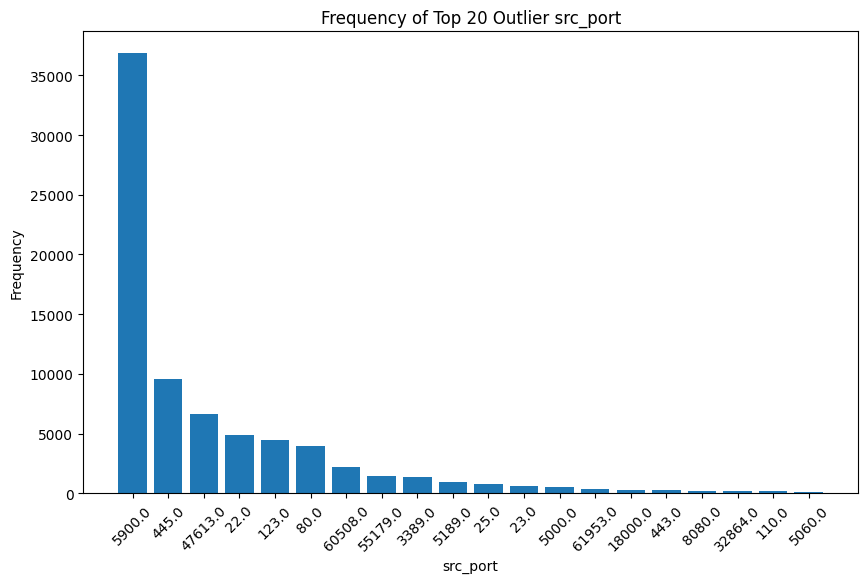

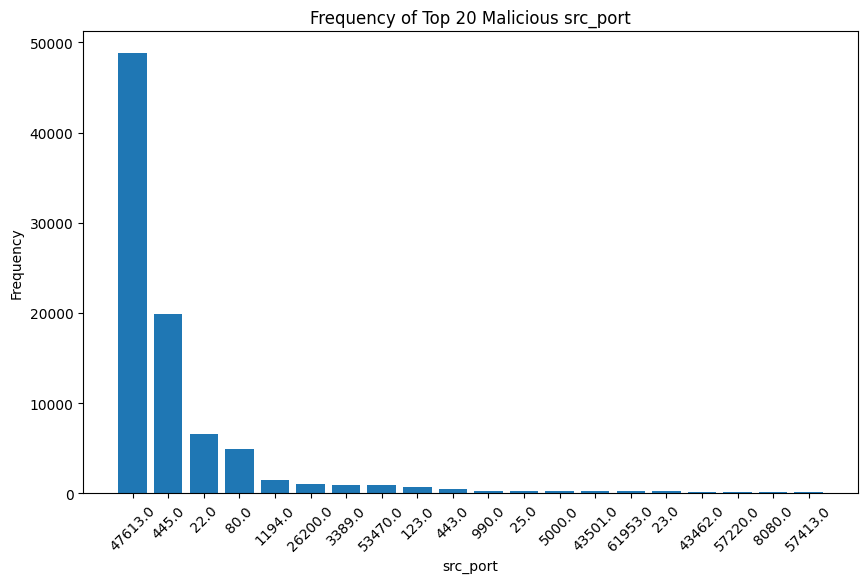

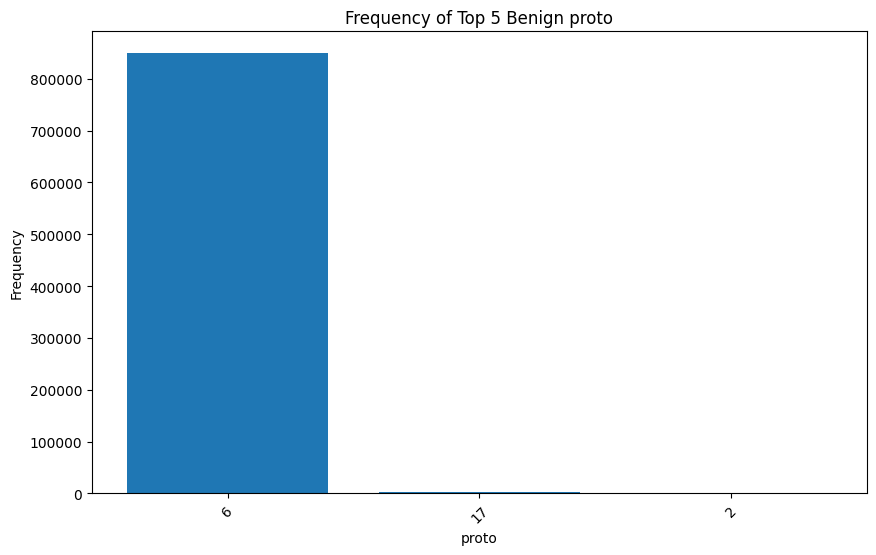

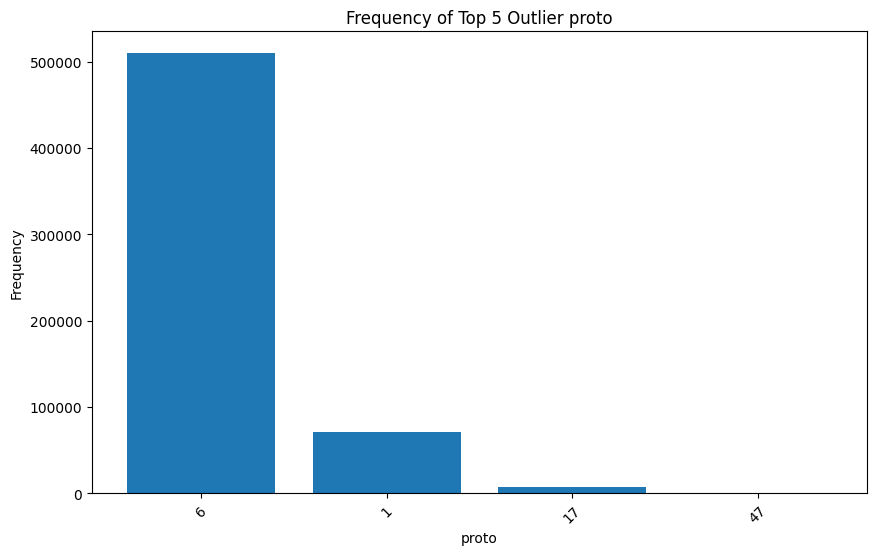

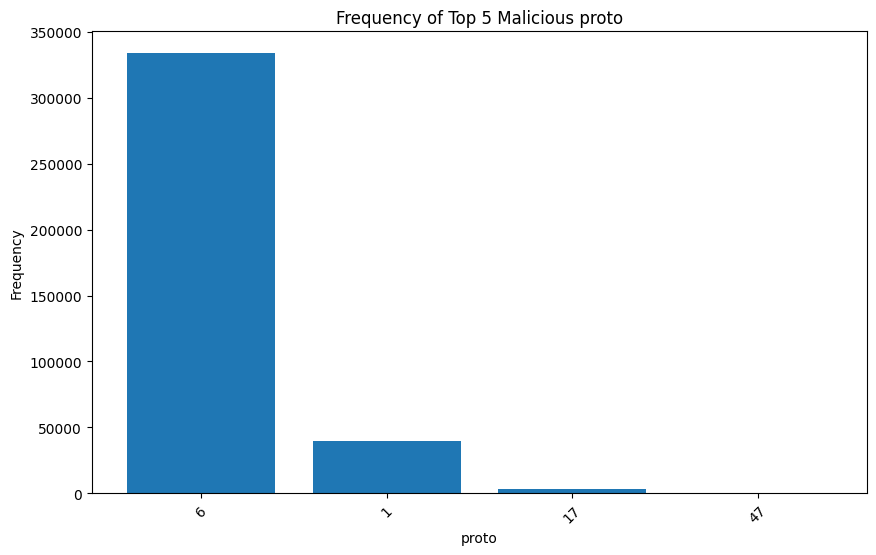

In [139]:
def N_Frequent_Values(c,n):
  top_n_benign = df[df['label'] == 0].value_counts(c).head(n).reset_index()
  top_n_outlier = df[df['label'] == 1].value_counts(c).head(n).reset_index()
  top_n_malicious = df[df['label'] == 2].value_counts(c).head(n).reset_index()

  plt.figure(figsize=(10,6))
  plt.title(f'Frequency of Top {n} Benign {c}')
  plt.xlabel(c)
  plt.ylabel('Frequency')
  plt.bar(top_n_benign[c].astype(str), top_n_benign['count'])
  plt.xticks(rotation=45)
  plt.show()

  plt.figure(figsize=(10,6))
  plt.title(f'Frequency of Top {n} Outlier {c}')
  plt.xlabel(c)
  plt.ylabel('Frequency')
  plt.bar(top_n_outlier[c].astype(str), top_n_outlier['count'])
  plt.xticks(rotation=45)
  plt.show()

  plt.figure(figsize=(10,6))
  plt.title(f'Frequency of Top {n} Malicious {c}')
  plt.xlabel(c)
  plt.ylabel('Frequency')
  plt.bar(top_n_malicious[c].astype(str), top_n_malicious['count'])
  plt.xticks(rotation=45)
  plt.show()

N_Frequent_Values('dest_port', 20)
N_Frequent_Values('src_port', 20)
N_Frequent_Values('proto', 5)

Destination ports seem to reveal information about the nature of a network packet. It would be useful to keep this in the classification. The same logic applies to *src_prt*. Protocol is almost always tcp which means we can likely drop this column but should test with adding this to the features as well.

### Drop Columns and Split Data

# Feature Column Descriptions

| Column Name     | Description     |
| :-------------- | :-------------- |
| avg_ipt | average interpacket Time |
| duration | The flow duration time, with microsecond precision |
| src_port | The source port number associated with the flow |
| dest_port	| The destination port number associated with the flow |
| bytes_in |	The number of bytes transmitted from source to destination |
| bytes_out	| The number of bytes transmitted from destination to source |


In [140]:
def Drop_Columns(c):
  df.drop(c, axis=1, inplace=True, errors='ignore')

# Drop useless/noisy columns
Drop_Columns('time_start')
Drop_Columns('time_end')
Drop_Columns('entropy')
Drop_Columns('src_ip')
Drop_Columns('dest_ip')
Drop_Columns('proto')
Drop_Columns('num_pkts_in')

X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=np.random.randint(100))
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")
print(f"DF shape: {df.shape}")

X_train Shape: (1454468, 8)
X_test Shape: (363618, 8)
y_train Shape: (1454468,)
y_test Shape: (363618,)
DF shape: (1818086, 9)


## Training and Benchmark

###  First Iteration: Decision Tree

Random Forests and Decision Trees are good for classification tasks where you have a mix of numerical and categorical features (like protocol or src_ip). They handle non-linearity, high-dimensional data, and feature importance.

https://www.sciencedirect.com/science/article/pii/S2772918424000481#:~:text=Their%20method%20utilized%20Random%20Forest%20as%20the%20base%20classifier


In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

models = []
def RandomForestBenchmark(n):

  forest_classifier = RandomForestClassifier(n_estimators=n, random_state=np.random.randint(100))

  fit_time_start = time.time()
  forest_classifier.fit(X_train, y_train)
  fit_time_end = time.time()
  fit_time = fit_time_end - fit_time_start
  print(f"Training duration for n = {n}: {fit_time}")

  predict_time_start = time.time()
  y_pred = forest_classifier.predict(X_test)
  predict_time_end = time.time()
  predict_time = predict_time_end - predict_time_start
  print(f"Prediction duration for n = {n}: {predict_time}")

  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy for n = {n}: {accuracy}")
  print(classification_report(y_test, y_pred))
  models.append(forest_classifier)

sizes = [50, 100, 200]
for size in sizes:
  RandomForestBenchmark(size)

Training duration for n = 50: 263.76075625419617
Prediction duration for n = 50: 5.963427782058716
Accuracy for n = 50: 0.9258617560186789
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170595
           1       0.87      0.90      0.89    117624
           2       0.84      0.79      0.82     75399

    accuracy                           0.93    363618
   macro avg       0.90      0.90      0.90    363618
weighted avg       0.93      0.93      0.93    363618

Training duration for n = 100: 517.4166116714478
Prediction duration for n = 100: 10.798593282699585
Accuracy for n = 100: 0.9262192740733407
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    170595
           1       0.87      0.90      0.89    117624
           2       0.84      0.80      0.82     75399

    accuracy                           0.93    363618
   macro avg       0.90      0.90      0.90    363618
weighted avg

### Save pickle of model

In [143]:
import pickle

filename = 'fortifi-ids.pkl'
filepath = f'/content/drive/MyDrive/Capstone Project/AI Model Training/{filename}'
with open(filepath, 'wb') as f:
  f.write(pickle.dumps(models[0]))
